In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Documents/Codes_divers/PlantBiophysics-paper-Quarto/notebooks/evaluation/Fig4`


In [2]:
### A Pluto.jl notebook ###
# v0.19.27

using Markdown
using InteractiveUtils




# Global evaluation of PlantBiophysics.jl : Taylor diagram

This Pluto notebook presents the computation of Fig. 4 from the scientific article. The notebook computes a Taylor diagram using results computed and stored in non-Pluto script available [here](https://github.com/VEZY/PlantBiophysics-paper/blob/main/tutorials/Fig4_PlantBiophysics_TaylorDiag_noPluto.jl).

## Importing the dependencies:



In [3]:
begin
    using Plots, CSV, DataFrames, Colors, Measures, TaylorDiag, PlotlyJS
    using PlantBiophysics
    plotlyjs()
end



WebIO._IJuliaInit()

Plots.PlotlyJSBackend()


## Reading the data



In [4]:
df_res = CSV.read("df_res.csv", DataFrame)



Row,Date,variable,simulated,origin,Cₐ,measured
,DateTime,String3,Float64,String31,Float64,Float64
1,2001-11-14T09:38:00,A,9.54724,PlantBiophysics.jl,188.35,10.5883
2,2001-11-14T09:48:00,A,19.2821,PlantBiophysics.jl,374.267,21.7167
3,2001-11-14T09:50:00,A,30.654,PlantBiophysics.jl,760.9,33.0167
4,2001-11-14T09:52:00,A,32.235,PlantBiophysics.jl,955.4,34.8167
5,2001-11-14T09:54:00,A,33.4133,PlantBiophysics.jl,1155.4,36.85
6,2001-11-14T09:56:00,A,29.3508,PlantBiophysics.jl,1157.62,32.15
7,2001-11-14T09:58:00,A,20.3233,PlantBiophysics.jl,1168.7,23.9833
8,2001-11-14T10:00:00,A,9.77645,PlantBiophysics.jl,1184.58,10.7583
9,2001-11-14T10:02:00,A,5.16737,PlantBiophysics.jl,1195.37,6.26167



## Computing statistics




In order to display a Taylor diagram, we need two statistics: 
- standard deviation (i.e. "amplitude" of evaluated data);
- correlation (i.e. pattern similarity between two datasets).

Standard deviations are normalized in order to represent all variables ($A$, $E$, $T_l$, $G_s$) on the same diagram.



In [5]:
begin
    VARS = ["A", "E", "Tl", "Gs"]
    Ss = zeros((4, 3))
    Cs = zeros((4, 3))

    for i in eachindex(VARS)
        var = VARS[i]

        # Loading observations and simulations for all three packages
        obs = filter(x -> (cmp.(x.variable, var) == 0) & (cmp.(x.origin, "PlantBiophysics.jl") == 0), df_res).measured
        modPB = filter(x -> (cmp.(x.variable, var) == 0) & (cmp.(x.origin, "PlantBiophysics.jl") == 0), df_res).simulated
        modPE = filter(x -> (cmp.(x.variable, var) == 0) & (cmp.(x.origin, "plantecophys") == 0), df_res).simulated
        modLG = filter(x -> (cmp.(x.variable, var) == 0) & (cmp.(x.origin, "LeafGasExchange.jl") == 0), df_res).simulated

        # Computing standard deviations
        S = [STD(modPB), STD(modPE), STD(modLG)]
        S = [S[i] / STD(obs) for i in eachindex(S)] # Normalization
        Ss[i, :] = S

        # Computing correlations
        C = [COR(obs, modPB), COR(obs, modPE), COR(obs, modLG)]
        Cs[i, :] = C
    end
end




## Plotting




### Plotting parameters



In [6]:
"""
	rgb(r, g, b, a)

Like `Colors.RGBA` but accepts colors in the 0-255 range.
"""
function rgb(r, g, b, a)
    return RGBA(r / 255, g / 255, b / 255, a)
end



rgb

In [7]:
begin
    # Colors for each package
    col_pb = (244, 124, 124)    # PlantBiophysics.jl
    col_lg = (93, 174, 139)     # LeafGasExchange.jl
    col_pe = (112, 161, 215)    # plantecophys
    transparency_col = 0.6      # Transparency for edges
    transparency_fill = 0.4     # Transparency for fill
    color_pb = rgb(col_pb..., transparency_col)
    color_pe = rgb(col_lg..., transparency_col)
    color_lg = rgb(col_pe..., transparency_col)
    fill_pb = rgb(col_pb..., transparency_fill)
    fill_pe = rgb(col_lg..., transparency_fill)
    fill_lg = rgb(col_pe..., transparency_fill)

    cols = [fill_pb, fill_lg, fill_pe]
    strkcols = [color_pb, color_lg, color_pe]

    # Parameters for fitting
    msize = 7                   # Marker size
    stw = 1.5
    legend_lab_size = 10
    xleg = 1.6                  # x-position for variables legend
    yleg = 0.4                  # y-position for variables legend
    nms = ["PlantBiophysics.jl", "plantecophys", "LeafGasExchange.jl"]
end




3-element Vector{String}:
 "PlantBiophysics.jl"
 "plantecophys"
 "LeafGasExchange.jl"


### Plotting Taylor diagram

Using the same Taylor diagram for all the data is correct thanks to STD normalization.



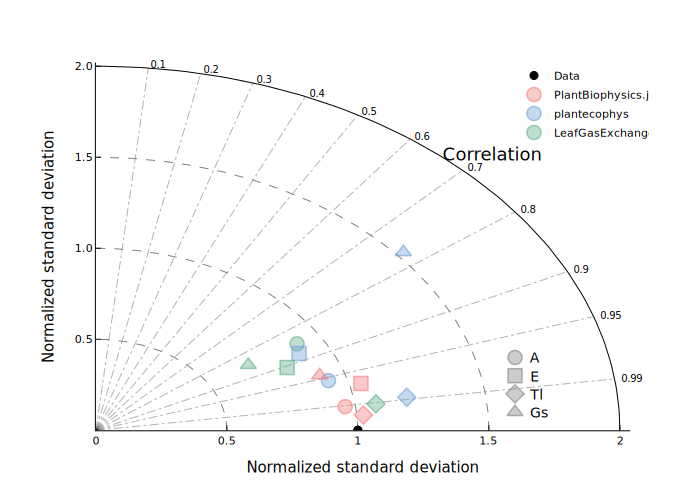

In [8]:
begin
    # Plotting initial Taylor diagram
    fig = taylordiagram([1], [1], [""], normalize=true, ang=pi / 2, rmsd_circ=false, figsize=600)

    # Adding data label
    Plots.scatter!([1], [0], label="Data", markerstrokecolor=:black, markercolor=:black)
    plot!(size=(600, 600))
    mks = [:circle, :rect, :diamond, :utriangle]


    for n in eachindex(mks)
        rho = Ss[n, :]
        theta = to_polar(Cs[n, :])
        for i in 1:length(theta)
            if n == 1
                lab = nms[i]
            else
                lab = ""
            end
            Plots.scatter!([cos.(theta[i]) .* rho[i]], [sin.(theta[i]) .* rho[i]], markerstrokecolor=strkcols[i], markercolor=cols[i], markershape=mks[n], markersize=msize, markerstrokewidth=stw, label=lab)
        end
        plot!(fontfamily="NotoSans-Regular.ttf", fontsize=12)
        scatter!([xleg], [yleg - 0.1 * (n - 1)], markerstrokecolor=:grey, markercolor=:grey, markershape=mks[n], markersize=msize, markerstrokewidth=stw, markerstrokealpha=0.6, markeralpha=0.4, label="")
        annotate!(xleg + 0.05, yleg - 0.1 * (n - 1) - 0.005, text(string(VARS[n]), :left, legend_lab_size))
    end
    plot!(legend=:topright, foreground_color_legend=nothing)
end



In [9]:
Plots.savefig(fig, "figure_global_simulation_taylor.png")



"/Users/arsouze/Documents/Codes_divers/PlantBiophysics-paper-Quarto/notebooks/evaluation/Fig4/figure_global_simulation_taylor.png"



### Explanation 

Taylor diagrams are tools invented and published in the 90s-00s allowing better visualisation of model realism evaluation. Via a clever use of relationship between RMSE, standard deviation and correlation, the Taylor diagram illustrates the accuracy of a model in polar coordinates. 

Here, the $\rho$ axis represents normalized standard deviation. 1 is the normalized standard deviation of observed data. If a modeled data point is higher (lower) than 1, it means that model induces higher (lower) standard deviation than observed data. For example, green diamond here has a more realistic standard deviation than blue diamond, i.e. blue diamond data tends to have exaggerated amplitudes with respect to data.

The $\theta$ axis represents correlation, i.e. the pattern similarity between observed and modeled data. Two datasets may have similar standard deviation but very different correlations (for instance if a dataset is highly dephased).

#### Toy example




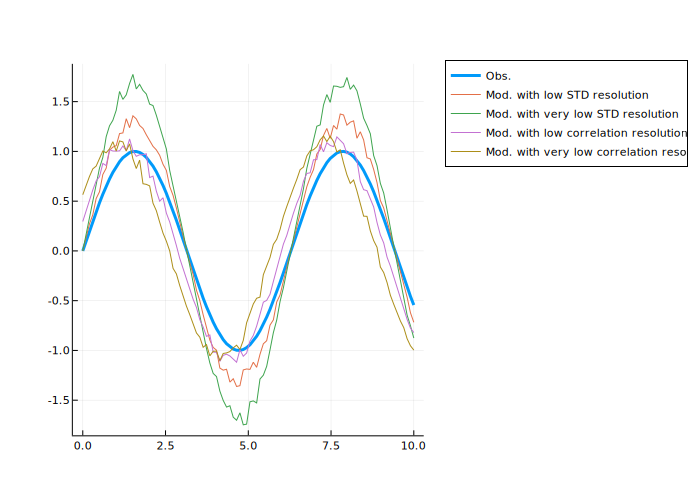

In [10]:
begin
    Lx = 100
    x = range(0, 10, Lx)
    obs = sin.(x)
    mod_lowSTD = 1.2 * sin.(x) + sin.(x) .* rand(Lx) * 0.2
    mod_verylowSTD = 1.6 * sin.(x) + sin.(x) .* rand(Lx) * 0.2
    mod_lowCOR = sin.(x .+ 0.3) .+ sin.(x) .* rand(Lx) * 0.2
    mod_verylowCOR = sin.(x .+ 0.6) .+ sin.(x) .* rand(Lx) * 0.2

    Plots.plot(x, obs, label="Obs.", linewidth=3)
    plot!(x, mod_lowSTD, label="Mod. with low STD resolution")
    plot!(x, mod_verylowSTD, label="Mod. with very low STD resolution")
    plot!(x, mod_lowCOR, label="Mod. with low correlation resolution")
    plot!(x, mod_verylowCOR, label="Mod. with very low correlation resolution")
    plot!(legend=:outertopright)
    plot!(size=(650, 400))
end




Here, we represent 5 datasets:
- `Obs` is the target dataset, a sinusoide.
- `Mod. with low STD resolution` the same than 'Obs' but with noise and amplified amplitude.
- `Mod. with very low STD resolution` the same than 'Obs' but with noise and even more amplified amplitude.
- `Mod. with low correlation resolution` the same than 'Obs' but with noise and shifted.
- `Mod. with very low correlation resolution` the same than 'Obs' but with noise and even more shifted.

Each "modeled" dataset is designed to illustrate behaviours on the Taylor diagram presented below.



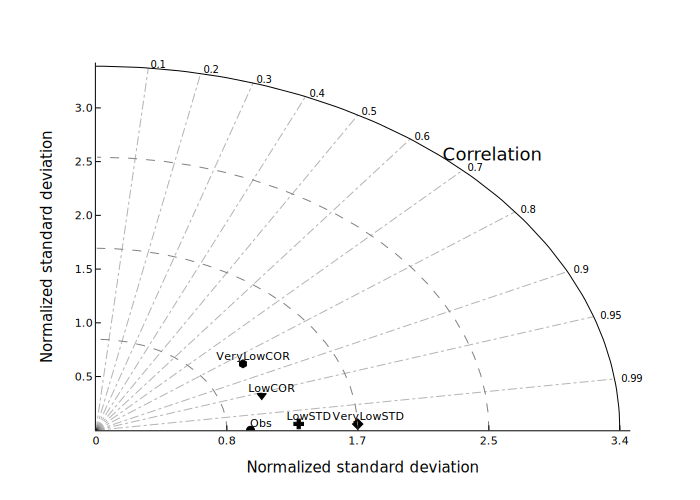

In [11]:
begin
    nmes = ["Obs", "LowSTD", "VeryLowSTD", "LowCOR", "VeryLowCOR"]
    S = [STD(obs), STD(mod_lowSTD), STD(mod_verylowSTD), STD(mod_lowCOR), STD(mod_verylowCOR)]
    S = S / STD(obs)
    C = [COR(obs, obs), COR(obs, mod_lowSTD), COR(obs, mod_verylowSTD), COR(obs, mod_lowCOR), COR(obs, mod_verylowCOR)]
    p = taylordiagram(S, C, nmes, rmsd_circ=false, normalize=true)
end




As expected, the Taylor diagram highlights the main failures of the datasets. The low and very low STD resolution ones have good correlation coefficients (near the $y=0$ axis) but are far away from the `Obs` point for standard deviation (distant from the center). The low and very low COR resolution ones have similar distance from center than the `Obs` point but move away from the $y=0$ axis (lower correlation coefficients).

